# AZMB Elsevier Article Retrieval 실습 노트북 (Full Pipeline · In-Notebook Engine)

이 실습은 **Elsevier ScienceDirect Search API**를 이용해 다음 전체 파이프라인을 실습합니다.

1) **키워드 조합 생성(필드 조합)**  
2) **Stage1 URL-builder 방식(apiKey 쿼리 파라미터)으로 JSON 메타데이터 수집**  
3) **(노트북 내부에서) 병렬 실행 + 전역 rate-limit + 라운드 재시도 구조로 대량 수집**  
4) **jsons/ 폴더의 JSON → CSV 통합**  
5) **중복 제거 + 비유효 제목 제거 + 태그 제거(clean title) 후 저장**
.

## 0. 사전 준비: Anaconda 설치 & 실습 환경 구축 (매우 중요)

### 0.1 Anaconda 설치 (Windows / macOS / Linux)

#### Windows
1. Anaconda 공식 페이지에서 Windows Installer(64-bit) 다운로드 후 설치  
   [아나콘다 공식 링크 (클릭)](https://www.anaconda.com/download)
2. 설치 옵션:  
   - **“Add Anaconda to my PATH”는 보통 비권장** (충돌 가능)  
   - 대신 **Anaconda Prompt**(또는 PowerShell)에서 `conda` 사용 권장  
3. 설치 확인 (Anaconda Prompt):
```bash
conda --version
python --version
```

---

### 0.2 Conda 가상환경 생성 + 패키지 설치

아래는 **실습용 권장 환경**입니다.
**아나콘다 가상환경을 먼저 만들어야합니다.** : 어떻게 만들지?
> 먼저 cmd를 켭니다. Window + R을 누르고 cmd 입력 및 엔터 / 이후 아래 커맨드 하나씩 차례대로 실행
```cmd
# (1) 새 환경 생성
conda create -n elsevier_lab python=3.10 -y

# (2) 환경 활성화
conda activate elsevier_lab

# (3) 필수 패키지 설치
pip install requests tqdm pandas matplotlib nbformat
```
> 이후 이 주피터 파일로 돌아와서 우측 상단에 select kernel버튼을 누르고 Select another kernel.. 을 누르고 elsevier_lab 가상환경 선택
---

### 0.3 Elsevier API Key 준비 
* 엘스비어 키 어떻게 만드나요?? 
   * [엘스비어개발자사이트(클릭)](https://dev.elsevier.com/) 해당 사이트에서 회원가입하고 만들면 됩니다.


In [20]:
# ============================================================
# 0) Imports & 폴더 준비 + Logging
# ============================================================
import os
import re
import json
import csv
import time
import random
import logging
from pathlib import Path
from itertools import product

import requests
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# (Notebook-friendly) parallel executor
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# -----------------------------
# Base logger (console)
# -----------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger("AZMB_FULL")

# -----------------------------
# folders
# -----------------------------
Path("output").mkdir(exist_ok=True)
Path("jsons").mkdir(exist_ok=True)
Path("cleaned_outputs").mkdir(exist_ok=True)

logger.info("노트북 준비 완료.")
logger.info(f"현재 작업 디렉토리(CWD): {Path('.').resolve()}")


2025-12-15 00:01:46,195 | INFO | 노트북 준비 완료.
2025-12-15 00:01:46,196 | INFO | 현재 작업 디렉토리(CWD): C:\Users\PSID_PC_20\Downloads


In [21]:
# ============================================================
# 1) Config  (INST_TOKEN 사용 안 함, apiKey query-param 방식)
# ============================================================

CONFIG = {
    # Elsevier ScienceDirect Search API 기본 엔드포인트
    "BASE_URL": "https://api.elsevier.com/content/search/sciencedirect",

    # ⚠️ 실습 편의를 위해 API_KEY를 여기에 직접 넣어둠(요청대로 유지).
    # 실제 연구/공유 환경에서는 환경변수(.env) 또는 별도 설정파일로 분리하는 것이 안전합니다.
    "API_KEY": "3c271c9aec7337d30416c170817761ad",  # 여기에 생성한 api키 넣으면 됩니다.

    # -----------------------------
    # Query defaults (Stage1 스크립트 기본값과 동일)
    # -----------------------------
    "FIELD": "title,abstract",  # 검색 결과에서 가져올 필드
    "SORT": "relevance",        # 정렬 기준
    "COUNT": 100,               # 한 번에 가져올 결과 수

    # -----------------------------
    # Rate limit + retry(라운드) 설정
    # -----------------------------
    "MIN_INTERVAL_BETWEEN_REQUESTS": 0.8,  # (초) 전역 요청 간 최소 간격
    "COOLDOWN_BETWEEN_ROUNDS": 10.0,       # (초) 라운드 사이 쉬는 시간
    "MAX_ROUNDS": 5,                       # 최대 라운드 수(실패 키워드 재시도)

    # -----------------------------
    # 병렬 실행 설정
    # -----------------------------
    "N_WORKERS": 4,  # 노트북에서는 ThreadPoolExecutor 권장(Windows 호환)

    # -----------------------------
    # Demo mode (교육용: 먼저 작은 규모로 테스트)
    # -----------------------------
    "DEMO_MODE": True,
    "DEMO_MAX_KEYWORDS": 20,

    # -----------------------------
    # HTTP 요청 안전장치
    # -----------------------------
    "HTTP_TIMEOUT": 10,  # (초) 요청 타임아웃
}

# 필수값 체크
if not CONFIG["API_KEY"]:
    raise RuntimeError(
        "Elsevier API 키(API_KEY)가 비어있습니다.\n"
        "상단 CONFIG에서 API_KEY를 설정한 뒤 다시 실행하세요."
    )

logger.info("설정(CONFIG) 로드 완료")
for k in [
    "BASE_URL", "FIELD", "SORT", "COUNT",
    "MIN_INTERVAL_BETWEEN_REQUESTS", "N_WORKERS",
    "DEMO_MODE", "DEMO_MAX_KEYWORDS"
]:
    logger.info(f"{k}: {CONFIG[k]}")


2025-12-15 00:01:49,864 | INFO | 설정(CONFIG) 로드 완료
2025-12-15 00:01:49,865 | INFO | BASE_URL: https://api.elsevier.com/content/search/sciencedirect
2025-12-15 00:01:49,865 | INFO | FIELD: title,abstract
2025-12-15 00:01:49,866 | INFO | SORT: relevance
2025-12-15 00:01:49,866 | INFO | COUNT: 100
2025-12-15 00:01:49,867 | INFO | MIN_INTERVAL_BETWEEN_REQUESTS: 0.8
2025-12-15 00:01:49,867 | INFO | N_WORKERS: 4
2025-12-15 00:01:49,868 | INFO | DEMO_MODE: True
2025-12-15 00:01:49,868 | INFO | DEMO_MAX_KEYWORDS: 20


## 2) AZMB ex-situ Protective Layer 키워드 조합 생성기 (Field1~5)

In [22]:
# ============================================================
# Keyword Generator (제공 코드 로직 유지)
# ============================================================

# (1) 키워드 생성 과정 로그를 파일/콘솔에 남기기 위한 로거 설정
kw_logger = logging.getLogger("keywordmaker")
kw_logger.setLevel(logging.INFO)

# - 동일 핸들러가 여러 번 붙는 것을 방지(노트북 재실행 시 중복 출력 방지)
if not any(
    isinstance(h, logging.FileHandler) and str(getattr(h, "baseFilename", "")).endswith("keywordmaker_AZMB.log")
    for h in kw_logger.handlers
):
    kw_logger.addHandler(logging.FileHandler("keywordmaker_AZMB.log", encoding="utf-8"))  # 파일 로그
    kw_logger.addHandler(logging.StreamHandler())  # 콘솔 로그

# (2) Field1~5 정의: 각 필드는 "검색에 넣을 문구 조각" 후보 리스트
# - 최종 쿼리는 Field1 × Field2 × Field3 × Field4 × Field5의 조합으로 생성됨
FIELD1 = ["aqueous zinc battery", "zinc metal battery"]

FIELD2 = ["zinc anode", "anode protection", "protective interface",
          "artificial interphase", "SEI layer"]

FIELD3 = [
    "ex-situ coating", "pre-coated zinc", "coated zinc", "protective layer",
    "artificial protective layer", "surface modification", "interfacial engineering"
]

FIELD4 = ["polymer", "hydrogel", "MOF", "MXene", "carbon", "oxide", "composite"]

FIELD5 = ["dendrite suppression", "corrosion resistance", "HER suppression", "cycling stability"]

ALL_FIELDS = [FIELD1, FIELD2, FIELD3, FIELD4, FIELD5]  # product(*ALL_FIELDS)에 바로 넣기 위한 묶음

def generate_combinations():
    # Field1~5의 모든 조합을 생성하여 '문장형 검색 쿼리' 리스트로 반환합니다.
    kw_logger.info("Field1~5 조합 생성 시작...")

    combos = []

    # product(*ALL_FIELDS): 카테시안 곱(모든 조합) 생성
    # tqdm: 진행률 표시(현재 몇 개 처리했는지 가시화)
    for combo in tqdm(list(product(*ALL_FIELDS)), desc="키워드 조합 생성 진행"):
        # combo는 (f1, f2, f3, f4, f5) 형태의 튜플
        # 혹시 공백/빈 문자열이 들어있으면 제거
        words = [c for c in combo if c.strip()]
        if not words:
            continue

        # 공백으로 이어붙여 쿼리 생성
        query = " ".join(words)

        # 아주 긴 쿼리는 API나 파일명에서 문제 될 수 있으므로 길이 제한(보수적으로 200)
        if len(query) > 200:
            query = query[:200]

        combos.append(query)

    kw_logger.info(f"중복 제거 전 조합 수: {len(combos):,}개")

    # 중복 제거(혹시 필드 내 중복이 있을 때 대비)
    combos = sorted(list(set(combos)))
    kw_logger.info(f"중복 제거 후 유니크 조합 수: {len(combos):,}개")

    return combos

def save_keywords_json(keywords, path="output/keyword_combinations_AZMB_exsitu.json"):
    # 생성된 키워드 리스트를 JSON으로 저장합니다.
    # - JSON은 리스트 형태: ["query1", "query2", ...]
    Path(path).parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(keywords, f, ensure_ascii=False, indent=2)
    kw_logger.info(f"키워드 JSON 저장 완료 -> {path}")

# (3) 실행: 조합 생성 → 파일 저장
keywords = generate_combinations()
save_keywords_json(keywords)

print("전체 키워드 개수:", len(keywords))
print("샘플(앞 5개):", keywords[:5])


Field1~5 조합 생성 시작...
2025-12-15 00:01:53,384 | INFO | Field1~5 조합 생성 시작...
키워드 조합 생성 진행: 100%|██████████| 1960/1960 [00:00<00:00, 979954.21it/s]
중복 제거 전 조합 수: 1,960개
2025-12-15 00:01:53,389 | INFO | 중복 제거 전 조합 수: 1,960개
중복 제거 후 유니크 조합 수: 1,960개
2025-12-15 00:01:53,392 | INFO | 중복 제거 후 유니크 조합 수: 1,960개
키워드 JSON 저장 완료 -> output/keyword_combinations_AZMB_exsitu.json
2025-12-15 00:01:53,397 | INFO | 키워드 JSON 저장 완료 -> output/keyword_combinations_AZMB_exsitu.json


전체 키워드 개수: 1960
샘플(앞 5개): ['aqueous zinc battery SEI layer artificial protective layer MOF HER suppression', 'aqueous zinc battery SEI layer artificial protective layer MOF corrosion resistance', 'aqueous zinc battery SEI layer artificial protective layer MOF cycling stability', 'aqueous zinc battery SEI layer artificial protective layer MOF dendrite suppression', 'aqueous zinc battery SEI layer artificial protective layer MXene HER suppression']


## 3) Stage1 Engine (노트북 내부 함수로 실행)

아래 함수는 Stage1 방식과 동일하게 URL을 조립합니다.

- `BASE_URL?apiKey=...&query=...&field=...&start=...&count=...&sort=...`
- `requests.get(url)` 호출
- JSON 저장: `jsons/<auto_name>.json`

> ⚠️ 원본 Stage1 스크립트의 `query.replace(' ', '%20')` 로직을 유지합니다.  
> 특수문자가 많은 쿼리(괄호/콜론/따옴표 등)는 URL 인코딩 이슈가 있을 수 있습니다.

In [23]:
# ============================================================
# Stage1: URL-builder 방식(apiKey query-param) + 저장 유틸
# ============================================================

# (1) Stage1 다운로드 로그를 파일/콘솔에 남기기 위한 로거
dl_logger = logging.getLogger("json_downloader")
dl_logger.setLevel(logging.INFO)

# - 노트북 재실행 시 핸들러 중복 부착 방지
if not any(
    isinstance(h, logging.FileHandler) and str(getattr(h, "baseFilename", "")).endswith("json_downloader.log")
    for h in dl_logger.handlers
):
    dl_logger.addHandler(logging.FileHandler("json_downloader.log", encoding="utf-8"))
    dl_logger.addHandler(logging.StreamHandler())

def build_url_stage1(query: str, field: str, start: int, count: int, sort: str, api_key: str) -> str:
    # ScienceDirect Search API URL 조립 (Stage1 방식)
    # 핵심: apiKey를 '헤더'가 아니라 URL 쿼리 파라미터로 넣음
    return (
        f"{CONFIG['BASE_URL']}"
        f"?apiKey={api_key}"
        f"&query={query.replace(' ', '%20')}"  # 공백만 치환(원본 Stage1 유지)
        f"&field={field}"
        f"&start={start}"
        f"&count={count}"
        f"&sort={sort}"
    )

def safe_filename(text: str, max_len: int = 150) -> str:
    # 파일명으로 쓰기 안전하게 문자열을 정리
    s = re.sub(r"[^\w\-\.]+", "_", str(text).strip())
    s = re.sub(r"_+", "_", s)
    return s[:max_len].strip("_") or "query"

def save_json(data: dict, path: Path) -> None:
    # JSON dict를 파일로 저장
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

def stage1_download_json(
    query: str,
    field: str = None,
    start: int = 0,
    count: int = None,
    sort: str = None,
    timeout: int = None,
) -> Path:
    # Stage1 방식으로 1회 요청 → jsons/에 저장 → 저장 경로 반환
    field = field or CONFIG["FIELD"]
    count = int(count or CONFIG["COUNT"])
    sort = sort or CONFIG["SORT"]
    timeout = int(timeout or CONFIG["HTTP_TIMEOUT"])

    # 1) URL 구성
    url = build_url_stage1(query, field, start, count, sort, CONFIG["API_KEY"])
    dl_logger.info("요청 URL 생성 완료:")
    dl_logger.info(url)

    # 2) API 호출
    dl_logger.info(f"API 요청 시작 (timeout={timeout}초)")
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()  # HTTP 에러(4xx/5xx)면 예외 발생
    dl_logger.info(f"API 응답 수신 완료 (HTTP {r.status_code})")

    # 3) JSON 파싱
    data = r.json()
    dl_logger.info("JSON 파싱 완료")

    # 4) 파일명 생성 + 저장
    safe_name = f"{safe_filename(query)}__{start}_{count}_{safe_filename(sort)}"[:150]
    out_path = Path("jsons") / f"{safe_name}.json"
    save_json(data, out_path)

    dl_logger.info(f"JSON 저장 완료 -> {out_path}")
    return out_path

def preview_entries(data: dict, n: int = 10) -> pd.DataFrame:
    # 저장된 JSON에서 entry 일부를 DataFrame으로 미리보기
    entries = data.get("search-results", {}).get("entry", []) or []
    rows = []
    for e in entries[:n]:
        rows.append({
            "title": e.get("dc:title", ""),
            "url": e.get("prism:url", ""),
            "doi": e.get("prism:doi", ""),
            "coverDate": e.get("prism:coverDate", ""),
            "aggregationType": e.get("prism:aggregationType", ""),
        })
    return pd.DataFrame(rows)

dl_logger.info("Stage1 노트북 엔진 준비 완료")


Stage1 노트북 엔진 준비 완료
2025-12-15 00:01:55,610 | INFO | Stage1 노트북 엔진 준비 완료


## 4) Stage1 단일 테스트 실행 (1개 키워드로 확인)

In [24]:
# ============================================================
# Single test run (노트북 내부 함수 호출)
# ============================================================

# (1) 키워드가 생성되어 있으면 첫 번째 키워드로 테스트
#     없으면 예시 문자열로 테스트
test_query = keywords[0] if keywords else "aqueous zinc battery zinc anode ex-situ coating polymer dendrite suppression"

try:
    # (2) count=25로 줄여서 빠르게 테스트(실습 초기에는 작은 값 권장)
    out_path = stage1_download_json(test_query, count=25)

    print("저장 완료:", out_path)

    # (3) 저장된 JSON 다시 읽어서 미리보기(제목/URL/DOI 등)
    data = json.loads(Path(out_path).read_text(encoding="utf-8"))
    display(preview_entries(data, n=10))

except Exception as e:
    # (4) 에러가 나면 메시지만 출력(초보자도 원인 파악에 도움)
    print("다운로드 실패:", e)


요청 URL 생성 완료:
2025-12-15 00:01:57,892 | INFO | 요청 URL 생성 완료:
https://api.elsevier.com/content/search/sciencedirect?apiKey=3c271c9aec7337d30416c170817761ad&query=aqueous%20zinc%20battery%20SEI%20layer%20artificial%20protective%20layer%20MOF%20HER%20suppression&field=title,abstract&start=0&count=25&sort=relevance
2025-12-15 00:01:57,894 | INFO | https://api.elsevier.com/content/search/sciencedirect?apiKey=3c271c9aec7337d30416c170817761ad&query=aqueous%20zinc%20battery%20SEI%20layer%20artificial%20protective%20layer%20MOF%20HER%20suppression&field=title,abstract&start=0&count=25&sort=relevance
API 요청 시작 (timeout=10초)
2025-12-15 00:01:57,895 | INFO | API 요청 시작 (timeout=10초)
API 응답 수신 완료 (HTTP 200)
2025-12-15 00:01:58,350 | INFO | API 응답 수신 완료 (HTTP 200)
JSON 파싱 완료
2025-12-15 00:01:58,351 | INFO | JSON 파싱 완료
JSON 저장 완료 -> jsons\aqueous_zinc_battery_SEI_layer_artificial_protective_layer_MOF_HER_suppression__0_25_relevance.json
2025-12-15 00:01:58,354 | INFO | JSON 저장 완료 -> jsons\aqueous_zinc

저장 완료: jsons\aqueous_zinc_battery_SEI_layer_artificial_protective_layer_MOF_HER_suppression__0_25_relevance.json


,title,url,doi,coverDate,aggregationType
0,A stable zinc anode with a hardwood kraft lign...,https://api.elsevier.com/content/article/pii/S...,,,
1,Unlocking the multidimensional application and...,https://api.elsevier.com/content/article/pii/S...,,,
2,MOF-derived defect-rich CeO<ce:inf loc=post>2<...,https://api.elsevier.com/content/article/pii/S...,,,
3,Achieving stable Zn anode via artificial inter...,https://api.elsevier.com/content/article/pii/S...,,,
4,Boosting tough metal Zn anode by MOF layer for...,https://api.elsevier.com/content/article/pii/S...,,,
5,Construction of zinc anode interfacial layer w...,https://api.elsevier.com/content/article/pii/S...,,,
6,Construction of stable Zn metal anode by inorg...,https://api.elsevier.com/content/article/pii/S...,,,
7,Ionic sieve 2D-MOF modified anode for long dur...,https://api.elsevier.com/content/article/pii/S...,,,
8,Bidirectional interface regulation strategies ...,https://api.elsevier.com/content/article/pii/S...,,,
9,Amorphous MOF as smart artificial solid/electr...,https://api.elsevier.com/content/article/pii/S...,,,


## 5) keyword_runner 엔진 (노트북 내부 구현)

요구한 엔진 로직(범위)과 동일한 구조로 구성합니다.

- 키워드 파일(JSON/TXT)을 읽고
- 각 키워드에 대해 Stage1 요청을 수행해 JSON 저장
- **전역 rate-limit**: 모든 worker가 공유하는 `last_call` 기반 간격 제한
- **라운드 재시도**: 실패 키워드만 다음 라운드로 넘김
- tqdm + logging + 실패 목록/상세 로그 저장

> 노트북에서는 Windows 호환성을 위해 **ThreadPoolExecutor**로 병렬 실행합니다.  
> (요청 간 최소 간격을 전역으로 제한하므로, “동시에 많이 때리는” 형태는 아닙니다.)

In [25]:
# ============================================================
# keyword_runner 엔진 (in-notebook)
# ============================================================

# (1) 러너 로그(라운드 진행/성공/실패)를 파일/콘솔에 남기기 위한 로거
runner_logger = logging.getLogger("keyword_runner")
runner_logger.setLevel(logging.INFO)

if not any(
    isinstance(h, logging.FileHandler) and str(getattr(h, "baseFilename", "")).endswith("keyword_runner.log")
    for h in runner_logger.handlers
):
    runner_logger.addHandler(logging.FileHandler("keyword_runner.log", encoding="utf-8"))
    runner_logger.addHandler(logging.StreamHandler())

# (2) 설정값을 편하게 사용하기 위해 변수로 꺼내둠
MIN_INTERVAL_BETWEEN_REQUESTS = float(CONFIG["MIN_INTERVAL_BETWEEN_REQUESTS"])
COOLDOWN_BETWEEN_ROUNDS = float(CONFIG["COOLDOWN_BETWEEN_ROUNDS"])

# (3) 전역 rate-limit (threads)
# - 여러 스레드가 동시에 실행되어도, 요청 사이 간격을 전체적으로 제한하기 위함
_rate_lock = threading.Lock()          # 동시에 접근하면 꼬이므로 lock 사용
_last_call_ts = {"t": 0.0}             # 마지막 요청 시각(공유 상태)

def _global_rate_wait():
    # 모든 worker가 공유하는 전역 rate-limit
    # - 마지막 호출 시각과 현재 시각의 차이가 MIN_INTERVAL보다 작으면 대기
    with _rate_lock:
        now = time.time()
        elapsed = now - _last_call_ts["t"]
        if elapsed < MIN_INTERVAL_BETWEEN_REQUESTS:
            time.sleep(MIN_INTERVAL_BETWEEN_REQUESTS - elapsed)
        _last_call_ts["t"] = time.time()

def _sleep_jitter():
    # 동일 타이밍 요청이 겹치는 것을 조금 완화하기 위한 랜덤 지터
    time.sleep(random.uniform(0.0, 0.3))

def load_keywords(path: str):
    # 키워드 파일을 읽어 리스트로 반환
    # - JSON: ["q1","q2",...]
    # - TXT : 줄 단위로 키워드
    ext = path.split(".")[-1].lower()
    if ext == "json":
        data = json.loads(Path(path).read_text(encoding="utf-8"))
        return [str(x).strip() for x in data if str(x).strip()]
    else:
        return [line.strip() for line in Path(path).read_text(encoding="utf-8").splitlines() if line.strip()]

def run_single_keyword(keyword: str):
    # 한 개 키워드 처리:
    # 1) 전역 rate-limit 대기
    # 2) 랜덤 지터
    # 3) Stage1 다운로드 함수 호출
    _global_rate_wait()
    _sleep_jitter()

    try:
        out_path = stage1_download_json(
            keyword,
            field=CONFIG["FIELD"],
            start=0,
            count=CONFIG["COUNT"],
            sort=CONFIG["SORT"],
            timeout=CONFIG["HTTP_TIMEOUT"]
        )
        return (keyword, True, str(out_path), "")
    except Exception as e:
        return (keyword, False, "", f"{type(e).__name__}: {e}")

def keyword_runner_in_notebook(
    keywords_file: str,
    n_workers: int = None,
    max_rounds: int = None,
):
    # keyword_runner의 '라운드 재시도' 구조를 노트북 내부에서 그대로 구현한 함수
    keywords = load_keywords(keywords_file)

    # 중복 제거(순서 유지)
    keywords = list(dict.fromkeys(keywords))
    runner_logger.info(f"키워드 로드 완료: {keywords_file} | 중복 제거 후 {len(keywords)}개")

    n_workers = int(n_workers or CONFIG["N_WORKERS"])
    max_rounds = int(max_rounds or CONFIG["MAX_ROUNDS"])
    runner_logger.info(f"병렬 워커 설정: {n_workers}개 (ThreadPoolExecutor)")
    runner_logger.info(f"최대 재시도 라운드 수: {max_rounds}")

    Path("output").mkdir(exist_ok=True)

    # 키워드별 시도 횟수 기록
    attempts = {kw: 0 for kw in keywords}

    # 아직 성공하지 못한 키워드 목록
    remaining = keywords[:]

    # 전체 결과(성공/실패/경로/에러/시도횟수) 누적
    all_results = []

    for round_idx in range(1, max_rounds + 1):
        if not remaining:
            runner_logger.info(f"남은 키워드가 없습니다. {round_idx} 라운드에서 종료합니다.")
            break

        runner_logger.info("=" * 80)
        runner_logger.info(f"=== {round_idx} / {max_rounds} 라운드 시작: 남은 키워드 {len(remaining)}개 ===")

        round_results = []
        with ThreadPoolExecutor(max_workers=n_workers) as ex:
            futures = {ex.submit(run_single_keyword, kw): kw for kw in remaining}

            for fut in tqdm(as_completed(futures), total=len(futures), desc=f"{round_idx}라운드 처리 진행"):
                kw = futures[fut]
                attempts[kw] += 1
                try:
                    result = fut.result()
                except Exception as e:
                    result = (kw, False, "", f"실행기 오류(ExecutorError): {type(e).__name__}: {e}")

                round_results.append(result)
                all_results.append((*result, attempts[kw]))

        # 이번 라운드에서 실패한 키워드만 모음
        failed = [kw for (kw, success, _, _) in round_results if not success]
        success_count = len(remaining) - len(failed)
        runner_logger.info(f"{round_idx} 라운드 완료 - 성공 {success_count}개, 실패 {len(failed)}개")

        if not failed:
            runner_logger.info("모든 키워드가 성공적으로 처리되었습니다. 재시도를 종료합니다.")
            remaining = []
            break

        # 다음 라운드에서는 실패한 키워드만 다시 시도
        remaining = failed

        if round_idx < max_rounds:
            runner_logger.info(
                f"실패 키워드 {len(remaining)}개를 다음 라운드에서 재시도합니다. "
                f"쿨다운 {COOLDOWN_BETWEEN_ROUNDS}초 대기 후 재시작합니다."
            )
            time.sleep(COOLDOWN_BETWEEN_ROUNDS)

    # 상세 로그 저장
    log_path = Path("output") / "keyword_runner_output.log"
    with open(log_path, "w", encoding="utf-8") as f:
        for (kw, success, outp, err, att) in all_results:
            f.write("=" * 80 + "\n")
            f.write(f"키워드: {kw}\n")
            f.write(f"성공 여부: {success}\n")
            f.write(f"시도 횟수: {att}\n")
            f.write(f"저장 경로: {outp}\n")
            f.write(f"오류: {err}\n\n")

    runner_logger.info(f"상세 실행 로그 저장 완료: {log_path}")

    # 최종 실패 목록 저장
    if remaining:
        failed_path = Path("output") / "failed_keywords.txt"
        failed_path.write_text("\n".join(remaining) + "\n", encoding="utf-8")
        runner_logger.warning(f"최종 실패 키워드 {len(remaining)}개: 목록 파일 저장 완료 -> {failed_path}")
    else:
        runner_logger.info("✅ 모든 키워드가 최소 1회 이상 성공적으로 다운로드되었습니다.")

    return {"전체": len(keywords), "실패": len(remaining), "실패목록": remaining, "로그경로": str(log_path)}

runner_logger.info("keyword_runner_in_notebook 준비 완료")


keyword_runner_in_notebook 준비 완료
2025-12-15 00:02:04,070 | INFO | keyword_runner_in_notebook 준비 완료


## 6) keyword_runner 실행 (DEMO: 앞 N개 키워드만)

In [26]:
# ============================================================
# DEMO 실행
# ============================================================

# (1) 전체 키워드 파일 로드
src_kw = Path("output/keyword_combinations_AZMB_exsitu.json")
all_kw = json.loads(src_kw.read_text(encoding="utf-8"))

# (2) DEMO_MODE면 앞 N개만 사용(처음에는 DEMO 권장)
if CONFIG["DEMO_MODE"]:
    demo = all_kw[: int(CONFIG["DEMO_MAX_KEYWORDS"])]
else:
    demo = all_kw

# (3) 데모 키워드 파일 저장(러너는 파일 입력을 받도록 설계됨)
demo_kw_path = Path("output") / "demo_keywords.json"
demo_kw_path.write_text(
    json.dumps(demo, ensure_ascii=False, indent=2),
    encoding="utf-8"
)
print("키워드 파일:", demo_kw_path, "| 개수=", len(demo))

# (4) 러너 실행
result = keyword_runner_in_notebook(
    keywords_file=str(demo_kw_path),
    n_workers=CONFIG["N_WORKERS"],
    max_rounds=CONFIG["MAX_ROUNDS"],
)

result


키워드 로드 완료: output\demo_keywords.json | 중복 제거 후 20개
2025-12-15 00:02:05,430 | INFO | 키워드 로드 완료: output\demo_keywords.json | 중복 제거 후 20개
병렬 워커 설정: 4개 (ThreadPoolExecutor)
2025-12-15 00:02:05,431 | INFO | 병렬 워커 설정: 4개 (ThreadPoolExecutor)
최대 재시도 라운드 수: 5
2025-12-15 00:02:05,433 | INFO | 최대 재시도 라운드 수: 5
2025-12-15 00:02:05,434 | INFO | ================================================================================
=== 1 / 5 라운드 시작: 남은 키워드 20개 ===
2025-12-15 00:02:05,436 | INFO | === 1 / 5 라운드 시작: 남은 키워드 20개 ===


키워드 파일: output\demo_keywords.json | 개수= 20


1라운드 처리 진행:   0%|          | 0/20 [00:00<?, ?it/s]요청 URL 생성 완료:
2025-12-15 00:02:05,502 | INFO | 요청 URL 생성 완료:
https://api.elsevier.com/content/search/sciencedirect?apiKey=3c271c9aec7337d30416c170817761ad&query=aqueous%20zinc%20battery%20SEI%20layer%20artificial%20protective%20layer%20MOF%20HER%20suppression&field=title,abstract&start=0&count=100&sort=relevance
2025-12-15 00:02:05,511 | INFO | https://api.elsevier.com/content/search/sciencedirect?apiKey=3c271c9aec7337d30416c170817761ad&query=aqueous%20zinc%20battery%20SEI%20layer%20artificial%20protective%20layer%20MOF%20HER%20suppression&field=title,abstract&start=0&count=100&sort=relevance
API 요청 시작 (timeout=10초)
2025-12-15 00:02:05,513 | INFO | API 요청 시작 (timeout=10초)
API 응답 수신 완료 (HTTP 200)
2025-12-15 00:02:06,163 | INFO | API 응답 수신 완료 (HTTP 200)
JSON 파싱 완료
2025-12-15 00:02:06,165 | INFO | JSON 파싱 완료
JSON 저장 완료 -> jsons\aqueous_zinc_battery_SEI_layer_artificial_protective_layer_MOF_HER_suppression__0_100_relevance.json
2025-12-15 0

{'전체': 20, '실패': 0, '실패목록': [], '로그경로': 'output\\keyword_runner_output.log'}

## 7) Stage2: jsons/ 폴더의 JSON → CSV 통합

- `search-results.entry[]`에서 `url`, `title` 추출
- `source_json`(원본 파일명) 추가
- `combined.csv` 저장

In [27]:
# ============================================================
# JSONs -> combined.csv
# ============================================================

# (1) jsons 폴더에서 JSON 파일 목록 가져오기
json_dir = Path("jsons")
out_csv = Path("combined.csv")

files = sorted(json_dir.glob("*.json"))
logger.info(f"JSON 파일 발견: {len(files)}개")

def parse_entries(data):
    # Elsevier Search API 응답 JSON 구조에서 entry 리스트를 추출하고
    # 필요한 컬럼(url, title)만 뽑아 rows로 반환
    entries = data.get("search-results", {}).get("entry", []) or []
    rows = []
    for e in entries:
        rows.append({
            "url": e.get("prism:url", ""),
            "title": e.get("dc:title", ""),
        })
    return rows

# (2) 모든 JSON을 순회하면서 row 누적
all_rows = []
for fpath in tqdm(files, desc="JSON 파싱 진행"):
    try:
        data = json.loads(fpath.read_text(encoding="utf-8"))
    except Exception as e:
        logger.error(f"JSON 로드 실패: {fpath.name} | 오류: {e}")
        continue

    rows = parse_entries(data)

    # (3) 어떤 JSON 파일에서 나온 row인지 추적 가능하게 source_json 추가
    for r in rows:
        r["source_json"] = fpath.name

    all_rows.extend(rows)

logger.info(f"파싱 완료: 총 누적 행 수={len(all_rows):,} (파일 수={len(files)}개)")

# (4) combined.csv로 저장
with open(out_csv, "w", encoding="utf-8-sig", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["url", "title", "source_json"])
    writer.writeheader()
    writer.writerows(all_rows)

logger.info(f"CSV 저장 완료: {out_csv} | 저장된 행 수={len(all_rows):,}")

# (5) 상위 일부 확인
logger.info("저장된 CSV 상위 10행 미리보기 출력")
pd.read_csv(out_csv).head(10)


2025-12-15 00:02:21,461 | INFO | JSON 파일 발견: 21개
JSON 파싱 진행: 100%|██████████| 21/21 [00:00<00:00, 1312.99it/s]
2025-12-15 00:02:21,482 | INFO | 파싱 완료: 총 누적 행 수=2,025 (파일 수=21개)
2025-12-15 00:02:21,500 | INFO | CSV 저장 완료: combined.csv | 저장된 행 수=2,025
2025-12-15 00:02:21,501 | INFO | 저장된 CSV 상위 10행 미리보기 출력


,url,title,source_json
0,https://api.elsevier.com/content/article/pii/S...,A stable zinc anode with a hardwood kraft lign...,aqueous_zinc_battery_SEI_layer_artificial_prot...
1,https://api.elsevier.com/content/article/pii/S...,Achieving stable Zn anode via artificial inter...,aqueous_zinc_battery_SEI_layer_artificial_prot...
2,https://api.elsevier.com/content/article/pii/S...,An artificial layer structure-modulated “high ...,aqueous_zinc_battery_SEI_layer_artificial_prot...
3,https://api.elsevier.com/content/article/pii/S...,Artificial aluminum-doped SiO<ce:inf loc=post>...,aqueous_zinc_battery_SEI_layer_artificial_prot...
4,https://api.elsevier.com/content/article/pii/S...,A trinity strategy enabled by iodine-loaded ni...,aqueous_zinc_battery_SEI_layer_artificial_prot...
5,https://api.elsevier.com/content/article/pii/S...,BaTiO<ce:inf loc=post>3</ce:inf> dressed in ca...,aqueous_zinc_battery_SEI_layer_artificial_prot...
6,https://api.elsevier.com/content/article/pii/S...,Construction of zinc anode interfacial layer w...,aqueous_zinc_battery_SEI_layer_artificial_prot...
7,https://api.elsevier.com/content/article/pii/S...,Ultrastrong bioinspired “brick-and-mortar” art...,aqueous_zinc_battery_SEI_layer_artificial_prot...
8,https://api.elsevier.com/content/article/pii/S...,Self-assembled polysilane artificial solid ele...,aqueous_zinc_battery_SEI_layer_artificial_prot...
9,https://api.elsevier.com/content/article/pii/S...,High-performance zinc anodes enabled by atmosp...,aqueous_zinc_battery_SEI_layer_artificial_prot...


## 8) Stage3: Post-processing (중복 제거 + 비유효 제목 제거 + 태그 제거)

1. URL 기준 중복 제거  
2. 제목 길이 < 25 제거  
3. 제목에 `|` 포함 제거  
4. `<...>` 태그 제거 → `title_clean` 생성  
5. `cleaned_outputs/ARTICEL_SEARCH_RESULT.csv` 저장

In [28]:
# ============================================================
# Cleaning pipeline (logging + tqdm)
# ============================================================

# (1) 클리닝 로그 로거 설정
clean_logger = logging.getLogger("cleaning")
clean_logger.setLevel(logging.INFO)

if not any(
    isinstance(h, logging.FileHandler) and str(getattr(h, "baseFilename", "")).endswith("data_cleaning.log")
    for h in clean_logger.handlers
):
    clean_logger.addHandler(logging.FileHandler("data_cleaning.log", encoding="utf-8"))
    clean_logger.addHandler(logging.StreamHandler())

# (2) 입출력 경로/컬럼명 설정
INPUT_CSV = "combined.csv"
OUTPUT_DIR = Path("cleaned_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

URL_COL = "url"
TITLE_COL = "title"

# (3) CSV 로드
df = pd.read_csv(INPUT_CSV)
clean_logger.info(f"CSV 로드 완료: {INPUT_CSV} | 행/열 크기(shape)={df.shape}")

# -----------------------------
# 1) URL 기준 중복 제거
# -----------------------------
before = len(df)
df = df.drop_duplicates(subset=[URL_COL]).reset_index(drop=True)
clean_logger.info(f"URL 기준 중복 제거: {before} -> {len(df)} (삭제 {before - len(df)}건)")

# -----------------------------
# 2) 제목 길이 기반 비유효값 제거 (길이 < 25)
# -----------------------------
df["title_length"] = df[TITLE_COL].astype(str).map(len)

before = len(df)
df = df[df["title_length"] >= 25].copy()
clean_logger.info(f"짧은 제목 제거(25자 미만): {before} -> {len(df)} (삭제 {before - len(df)}건)")

# -----------------------------
# 3) 제목에 '|' 포함된 행 제거
# -----------------------------
pipe_mask = df[TITLE_COL].astype(str).str.contains(r"\|", na=False)
pipe_count = int(pipe_mask.sum())
clean_logger.info(f"제목에 '|' 문자가 포함된 건수: {pipe_count}건")

df = df[~pipe_mask].copy()
clean_logger.info(f"'|' 포함 제목 제거 완료: 현재 행 수={len(df)}")

# -----------------------------
# 4) XML/Math 태그 제거 후 title_clean 생성
# -----------------------------
TAG_PATTERN = re.compile(r"<[^>]+>")  # <...> 형태 태그 매칭

def clean_title(text: str) -> str:
    # Elsevier 메타데이터에 포함될 수 있는 태그(<...>)를 제거하고 공백을 정리
    s = "" if pd.isna(text) else str(text)
    s = TAG_PATTERN.sub("", s)              # 태그 제거
    s = re.sub(r"\s+", " ", s).strip()      # 여러 공백 -> 하나로
    return s

# tqdm.pandas를 활성화하면 progress_apply에서 진행률이 표시됩니다.
tqdm.pandas(desc="제목 정제 진행")

clean_logger.info("제목 정제 시작: 태그(<...>) 제거 및 공백 정리")
df["title_clean"] = df[TITLE_COL].progress_apply(clean_title)
df["title_length_clean"] = df["title_clean"].astype(str).map(len)
clean_logger.info("제목 정제 완료: title_clean / title_length_clean 컬럼 생성")

# (5) 저장
out_path = OUTPUT_DIR / "ARTICEL_SEARCH_RESULT.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
clean_logger.info(f"정제 CSV 저장 완료: {out_path} | 행/열 크기(shape)={df.shape}")

# (6) 상위 일부 확인
clean_logger.info("정제 결과 상위 10행 미리보기 출력")
df.head(10)


CSV 로드 완료: combined.csv | 행/열 크기(shape)=(2025, 3)
2025-12-15 00:02:21,552 | INFO | CSV 로드 완료: combined.csv | 행/열 크기(shape)=(2025, 3)
URL 기준 중복 제거: 2025 -> 258 (삭제 1767건)
2025-12-15 00:02:21,556 | INFO | URL 기준 중복 제거: 2025 -> 258 (삭제 1767건)
짧은 제목 제거(25자 미만): 258 -> 258 (삭제 0건)
2025-12-15 00:02:21,560 | INFO | 짧은 제목 제거(25자 미만): 258 -> 258 (삭제 0건)
제목에 '|' 문자가 포함된 건수: 2건
2025-12-15 00:02:21,563 | INFO | 제목에 '|' 문자가 포함된 건수: 2건
'|' 포함 제목 제거 완료: 현재 행 수=256
2025-12-15 00:02:21,566 | INFO | '|' 포함 제목 제거 완료: 현재 행 수=256
제목 정제 시작: 태그(<...>) 제거 및 공백 정리
2025-12-15 00:02:21,569 | INFO | 제목 정제 시작: 태그(<...>) 제거 및 공백 정리
제목 정제 진행: 100%|██████████| 256/256 [00:00<00:00, 85387.02it/s]
제목 정제 완료: title_clean / title_length_clean 컬럼 생성
2025-12-15 00:02:21,577 | INFO | 제목 정제 완료: title_clean / title_length_clean 컬럼 생성
정제 CSV 저장 완료: cleaned_outputs\ARTICEL_SEARCH_RESULT.csv | 행/열 크기(shape)=(256, 6)
2025-12-15 00:02:21,583 | INFO | 정제 CSV 저장 완료: cleaned_outputs\ARTICEL_SEARCH_RESULT.csv | 행/열 크기(shape)=(256, 6)
정

,url,title,source_json,title_length,title_clean,title_length_clean
0,https://api.elsevier.com/content/article/pii/S...,A stable zinc anode with a hardwood kraft lign...,aqueous_zinc_battery_SEI_layer_artificial_prot...,146,A stable zinc anode with a hardwood kraft lign...,146
1,https://api.elsevier.com/content/article/pii/S...,Achieving stable Zn anode via artificial inter...,aqueous_zinc_battery_SEI_layer_artificial_prot...,113,Achieving stable Zn anode via artificial inter...,113
2,https://api.elsevier.com/content/article/pii/S...,An artificial layer structure-modulated “high ...,aqueous_zinc_battery_SEI_layer_artificial_prot...,109,An artificial layer structure-modulated “high ...,109
3,https://api.elsevier.com/content/article/pii/S...,Artificial aluminum-doped SiO<ce:inf loc=post>...,aqueous_zinc_battery_SEI_layer_artificial_prot...,152,Artificial aluminum-doped SiO2 aerogel coating...,126
4,https://api.elsevier.com/content/article/pii/S...,A trinity strategy enabled by iodine-loaded ni...,aqueous_zinc_battery_SEI_layer_artificial_prot...,125,A trinity strategy enabled by iodine-loaded ni...,125
5,https://api.elsevier.com/content/article/pii/S...,BaTiO<ce:inf loc=post>3</ce:inf> dressed in ca...,aqueous_zinc_battery_SEI_layer_artificial_prot...,123,BaTiO3 dressed in carbon multifunctional layer...,97
6,https://api.elsevier.com/content/article/pii/S...,Construction of zinc anode interfacial layer w...,aqueous_zinc_battery_SEI_layer_artificial_prot...,157,Construction of zinc anode interfacial layer w...,157
7,https://api.elsevier.com/content/article/pii/S...,Ultrastrong bioinspired “brick-and-mortar” art...,aqueous_zinc_battery_SEI_layer_artificial_prot...,84,Ultrastrong bioinspired “brick-and-mortar” art...,84
8,https://api.elsevier.com/content/article/pii/S...,Self-assembled polysilane artificial solid ele...,aqueous_zinc_battery_SEI_layer_artificial_prot...,119,Self-assembled polysilane artificial solid ele...,119
9,https://api.elsevier.com/content/article/pii/S...,High-performance zinc anodes enabled by atmosp...,aqueous_zinc_battery_SEI_layer_artificial_prot...,117,High-performance zinc anodes enabled by atmosp...,117


## 9) title_clean 길이 분포 시각화

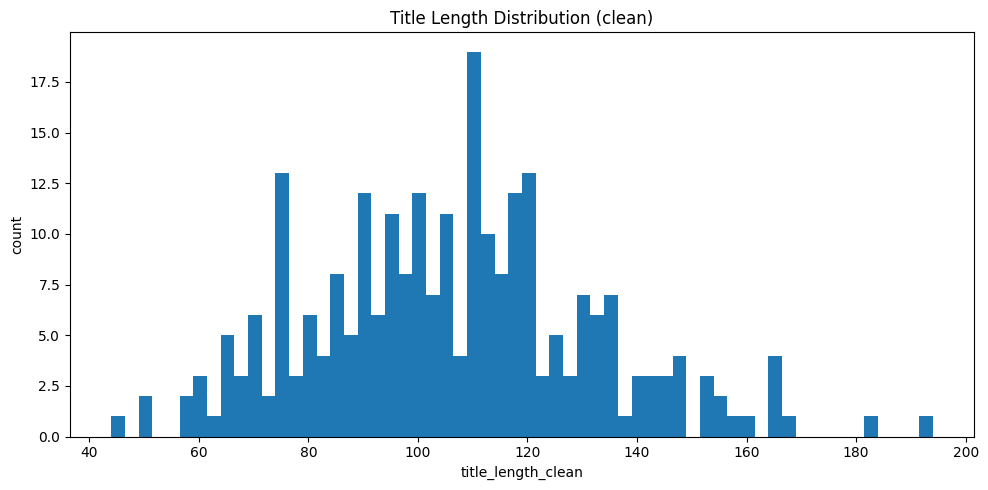

In [29]:
# (1) 클린 결과 CSV 로드
df_clean = pd.read_csv("cleaned_outputs/ARTICEL_SEARCH_RESULT.csv")

# (2) 제목 길이 분포를 히스토그램으로 확인
plt.figure(figsize=(10, 5))
plt.hist(df_clean["title_length_clean"].dropna().values, bins=60)
plt.title("Title Length Distribution (clean)")
plt.xlabel("title_length_clean")
plt.ylabel("count")
plt.tight_layout()
plt.show()
